In [61]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn import linear_model
from scipy import stats
from statsmodels.api import add_constant
%matplotlib inline

In [2]:
# Import high frequency data

path =r'D:\data_raw' # Please put all .csv documents into one folder
company_list = ['AAPL', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'DIS', 'DWDP', 'GE', 'GS', \
                           'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', \
                            'MSFT', 'NKE', 'PFE', 'PG', 'TRV', 'UNH', 'UTX', 'V', 'VZ', 'WMT', 'XOM' ] # Input company name as a list
company_data = {} # Store company data as a dictionary: {company_name1: data1, company_name2: data2, ...}
for company in company_list:
    frame = pd.DataFrame()
    list_ = []
    allFiles = glob.glob(path + '/' +company +'_' + '*.csv')
    allFiles.reverse()
    #print (allFiles)
    for file_ in allFiles:
        df = pd.read_csv(file_, index_col=None, header=0, usecols=[0,1], skiprows=[1,])
        list_.append(df)
    frame = pd.concat(list_)
    company_data[company] = frame
    company_data[company].index = pd.RangeIndex(len(company_data[company].index))

In [3]:
high_mom_daily_data = {}
for com in company_data.keys():
    list_temp = []
    date_idx = []
    high_mom_daily_data[com] = pd.DataFrame(columns = ['RDVar', 'RDSkew', 'RDKurt'])
    date_idx_s = np.array(company_data[com].loc[pd.isnull(company_data[com].Close), ].index)
    date_idx_e = np.append(date_idx_s[1:], company_data[com].shape[0])
    for i, j in zip(date_idx_s, date_idx_e):
        date_idx.append(company_data[com]['Time Interval'][i][:9])
        log_r = np.log(company_data[com].Close[i+1: j]).diff().dropna()
        RDVar = np.sum(np.square(log_r))
        RDSkew = np.sqrt(len(log_r)) * np.sum(log_r**3) / RDVar**1.5
        RDKurt = len(log_r) * np.sum(log_r**4) / RDVar**2
        list_temp.append({'RDVar': RDVar, 'RDSkew': RDSkew, 'RDKurt': RDKurt})
    high_mom_daily_data[com] = high_mom_daily_data[com].append(list_temp)
    high_mom_daily_data[com].index = date_idx

In [4]:
# Import daily data

path_ = r'D:\daily_data'
company_daily = {}
for com in company_list:
    file = glob.glob(path_ + '/' +com + '*.csv')[0]
    company_daily[com] = pd.read_csv(file, index_col = None, header = 0, usecols=[6])
    company_daily[com]['Daily_logp'] = np.log(company_daily[com].iloc[:, 0])
    company_daily[com]['Daily_logr'] = company_daily[com]['Daily_logp'].diff()
    company_daily[com].index = high_mom_daily_data['AAPL'].index

In [5]:
# Import DJIA daily
DJIA = pd.read_csv('D:\daily_data\DJI_daily.csv', index_col = None, header = 0, usecols=[6])
DJIA.index = high_mom_daily_data['AAPL'].index

In [6]:
DJIA['daily_r'] = np.log(DJIA.iloc[:, 0]).diff()

In [7]:
# Delete two dates
date_to_delete = ['13AUG2013', '12SEP2016']
for com in high_mom_daily_data.keys():
    if date_to_delete[0] in high_mom_daily_data[com].index:
        high_mom_daily_data[com].drop(date_to_delete[0], inplace = True)
    if date_to_delete[0] in company_daily[com].index:
        company_daily[com].drop(date_to_delete[0], inplace = True)
    if date_to_delete[0] in DJIA.index:
        DJIA.drop(date_to_delete[0], inplace = True)
    if date_to_delete[1] in high_mom_daily_data[com].index:
        high_mom_daily_data[com].drop(date_to_delete[1], inplace = True)
    if date_to_delete[1] in company_daily[com].index:
        company_daily[com].drop(date_to_delete[1], inplace = True)
    if date_to_delete[1] in DJIA.index:
        DJIA.drop(date_to_delete[1], inplace = True)

In [8]:
# Combine two dataframes
for com in high_mom_daily_data.keys():
    high_mom_daily_data[com]['DR'] = company_daily[com].Daily_logr

In [9]:
# Save data
for com in high_mom_daily_data.keys():
    high_mom_daily_data[com].to_csv('D:\\output_data\\'+com+'.csv')

In [10]:
# daily close price by company matrix
price_com_mat = pd.DataFrame(columns = company_list)
for com in company_list:
    price_com_mat[com] = company_daily[com].iloc[:,0]

In [11]:
price_com_mat.to_csv('D:\\output_data\\'+'price_com_mat'+'.csv')

In [12]:
# Construct weekly data (5 trading days a week)
weekly_data = {}
for com in high_mom_daily_data.keys():
    weekly_data[com] = pd.DataFrame()
    weekly_data[com]['WR'] = high_mom_daily_data[com]['DR'].rolling(5).sum()[4::5]
    weekly_data[com]['RVol'] = np.sqrt(252.*high_mom_daily_data[com]['RDVar'].rolling(5).mean()[4::5])
    weekly_data[com]['RSkew'] = high_mom_daily_data[com]['RDSkew'].rolling(5).mean()[4::5]
    weekly_data[com]['RKurt'] = high_mom_daily_data[com]['RDKurt'].rolling(5).mean()[4::5]

In [13]:
DJIA_weekly = DJIA['daily_r'].rolling(5).sum()[4::5]

In [57]:
#for com in weekly_data.keys():
    #print (weekly_data[com].shape)

In [16]:
# Split weekly data into train and test data
weekly_test_data = {}
for com in weekly_data.keys():
    weekly_test_data[com] = weekly_data[com][-50: ]
    weekly_data[com] = weekly_data[com][:-50]

In [58]:
total_week = weekly_data['AAPL'].shape[0]

In [21]:
# Cross sectional regression
company_beta_pval = pd.DataFrame(columns = ['vol_intercept', 'b_vol', 'vol_p_val', 'skew_intercept', 'b_skew', \
                                                                                   'skew_p_val','kurt_intercept','b_kurt', 'kurt_p_val'])
list_cbp = []
for i in range(total_week-1):
    next_return =[]
    cur_vol = []
    cur_skew = []
    cur_kurt = []
    for com in weekly_data.keys():
        next_return.append(weekly_data[com].WR[i+1])
        cur_vol.append(weekly_data[com].RVol[i])
        cur_skew.append(weekly_data[com].RSkew[i])
        cur_kurt.append(weekly_data[com].RKurt[i])
    cur_vol = add_constant(cur_vol)
    cur_skew = add_constant(cur_skew)
    cur_kurt = add_constant(cur_kurt)
    lm_vol = sm.OLS(next_return, cur_vol).fit()
    lm_skew = sm.OLS(next_return, cur_skew).fit()
    lm_kurt = sm.OLS(next_return, cur_kurt).fit()
    
    list_cbp.append({'vol_intercept': lm_vol.params[0], 'b_vol': lm_vol.params[1], 'vol_p_val': lm_vol.pvalues[1], \
                                 'skew_intercept': lm_skew.params[0], 'b_skew': lm_skew.params[1], 'skew_p_val': lm_skew.pvalues[1],\
                                  'kurt_intercept': lm_kurt.params[0], 'b_kurt': lm_kurt.params[1], 'kurt_p_val': lm_kurt.pvalues[1]})
company_beta_pval = company_beta_pval.append(list_cbp)

In [72]:
# IC time series of vol, skew and kurt
weekly_IC = pd.DataFrame(columns = ['vol_Rank_IC', 'vol_pvalue','skew_Rank_IC', 'skew_pvalue', 'kurt_Rank_IC', 'kurt_pvalue'])
list_dict = []
for i in range(total_week-1):
    next_return =[]
    cur_vol = []
    cur_skew = []
    cur_kurt = []
    for com in weekly_data.keys():
        next_return.append(weekly_data[com].WR[i+1])
        cur_vol.append(weekly_data[com].RVol[i])
        cur_skew.append(weekly_data[com].RSkew[i])
        cur_kurt.append(weekly_data[com].RKurt[i])
    
    vol_IC, vol_p = stats.spearmanr(cur_vol, next_return)
    skew_IC, skew_p = stats.spearmanr(cur_skew, next_return)
    kurt_IC, kurt_p = stats.spearmanr(cur_kurt, next_return)
    
    list_dict.append({'vol_Rank_IC': vol_IC, 'vol_pvalue': vol_p, 'skew_Rank_IC': skew_IC, 'skew_pvalue': skew_p, \
                              'kurt_Rank_IC': kurt_IC, 'kurt_pvalue': kurt_p}) 
weekly_IC = weekly_IC.append(list_dict)

In [75]:
IC_mean = weekly_IC.mean()
IR = weekly_IC.std()
IC_IR = IC_mean / IR
IC_IR

vol_Rank_IC     0.028081
vol_pvalue      1.254515
skew_Rank_IC   -0.093050
skew_pvalue     1.501494
kurt_Rank_IC   -0.072898
kurt_pvalue     1.629400
dtype: float64

In [76]:
weekly_IC.head()

,vol_Rank_IC,vol_pvalue,skew_Rank_IC,skew_pvalue,kurt_Rank_IC,kurt_pvalue
0,0.020247,0.915427,0.300145,0.107068,0.242074,0.197460
1,-0.324619,0.080082,-0.076093,0.689415,-0.064968,0.733039
2,-0.546001,0.001802,0.072311,0.704146,-0.054511,0.774805
3,0.216264,0.251033,-0.314162,0.090888,0.131717,0.487796
4,-0.426076,0.018890,-0.122594,0.518677,-0.038714,0.839048


Positive significant rate:  0.08 Negative significant rate:  0.08


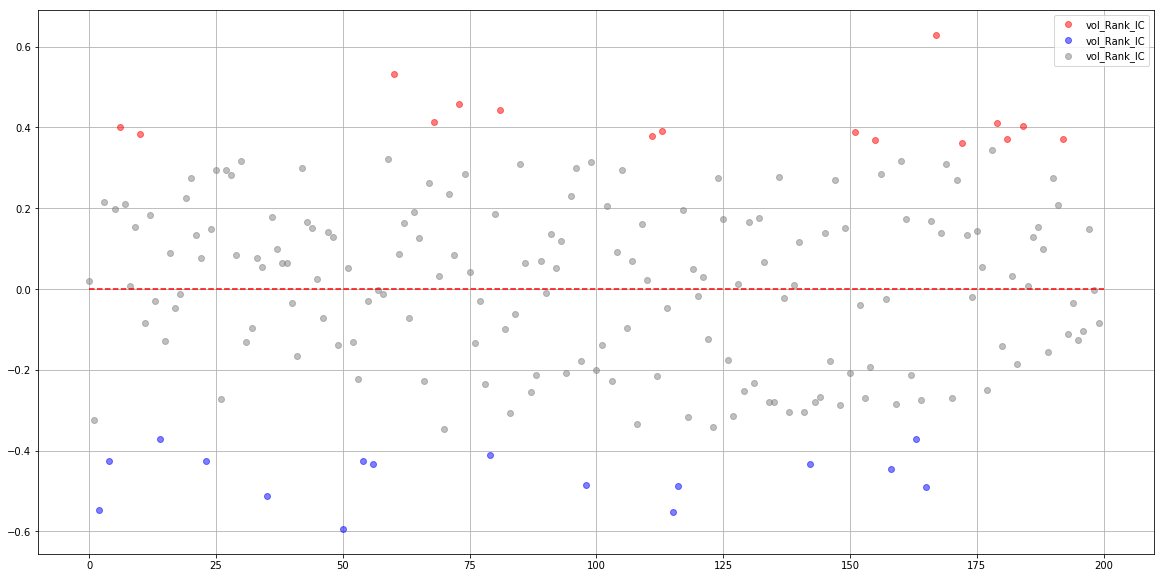

In [95]:
plt.figure(figsize=(20,10))
x11 = weekly_IC.vol_pvalue[(weekly_IC.vol_pvalue < 0.05) & (weekly_IC.vol_Rank_IC >= 0)].index
y11 = weekly_IC.vol_Rank_IC[x11]
x12 = weekly_IC.vol_pvalue[(weekly_IC.vol_pvalue < 0.05) & (weekly_IC.vol_Rank_IC < 0)].index
y12 = weekly_IC.vol_Rank_IC[x12]
x2 = weekly_IC.vol_pvalue[weekly_IC.vol_pvalue >= 0.05].index
y2 = weekly_IC.vol_Rank_IC[x2]
print('Positive significant rate: ', len(x11)/weekly_IC.shape[0], 'Negative significant rate: ', len(x12)/weekly_IC.shape[0])
plt.plot(x11, y11, 'o', alpha=0.5, color='red')
plt.plot(x12, y12, 'o', alpha=0.5, color='blue')
plt.plot(x2, y2, 'o', alpha=0.5, label='vol_Rank_IC', color='grey')
plt.plot(range(201), [0 for i in range(201)], 'r--')
plt.legend(loc='upper right')
plt.grid()
plt.show()

Positive significant rate:  0.03 Negative significant rate:  0.08


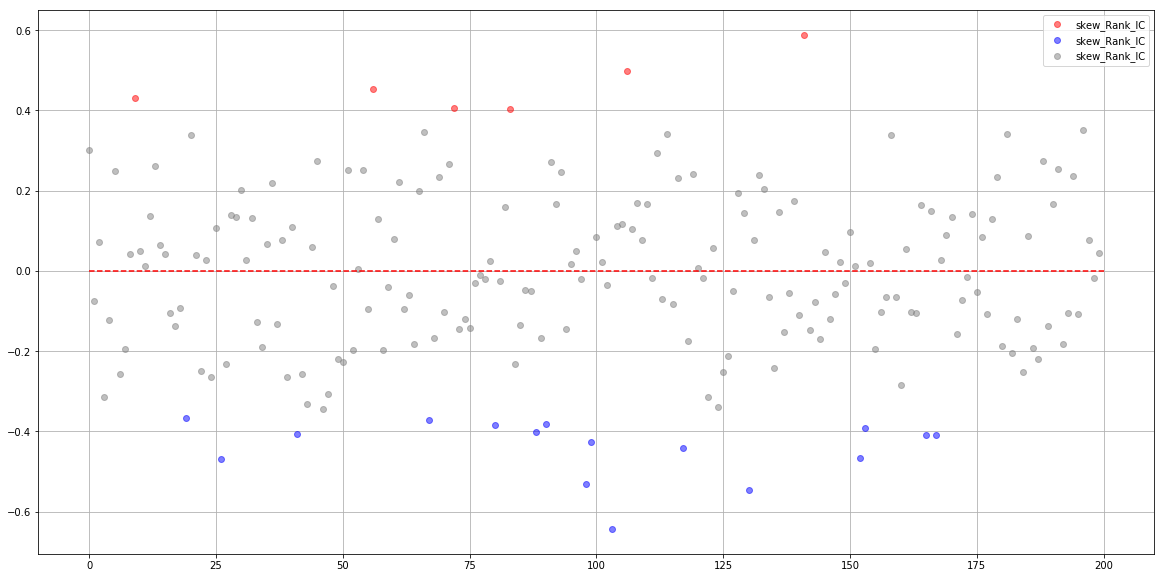

In [96]:
plt.figure(figsize=(20,10))
x11 = weekly_IC.skew_pvalue[(weekly_IC.skew_pvalue < 0.05) & (weekly_IC.skew_Rank_IC >= 0)].index
y11 = weekly_IC.skew_Rank_IC[x11]
x12 = weekly_IC.skew_pvalue[(weekly_IC.skew_pvalue < 0.05) & (weekly_IC.skew_Rank_IC < 0)].index
y12 = weekly_IC.skew_Rank_IC[x12]
x2 = weekly_IC.skew_pvalue[weekly_IC.skew_pvalue >= 0.05].index
y2 = weekly_IC.skew_Rank_IC[x2]
print('Positive significant rate: ', len(x11)/weekly_IC.shape[0], 'Negative significant rate: ', len(x12)/weekly_IC.shape[0])
plt.plot(x11, y11, 'o', alpha=0.5, color='red')
plt.plot(x12, y12, 'o', alpha=0.5, color='blue')
plt.plot(x2, y2, 'o', alpha=0.5, label='skew_Rank_IC', color='grey')
plt.plot(range(201), [0 for i in range(201)], 'r--')
plt.legend(loc='upper right')
plt.grid()
plt.show()

Positive significant rate:  0.03 Negative significant rate:  0.02


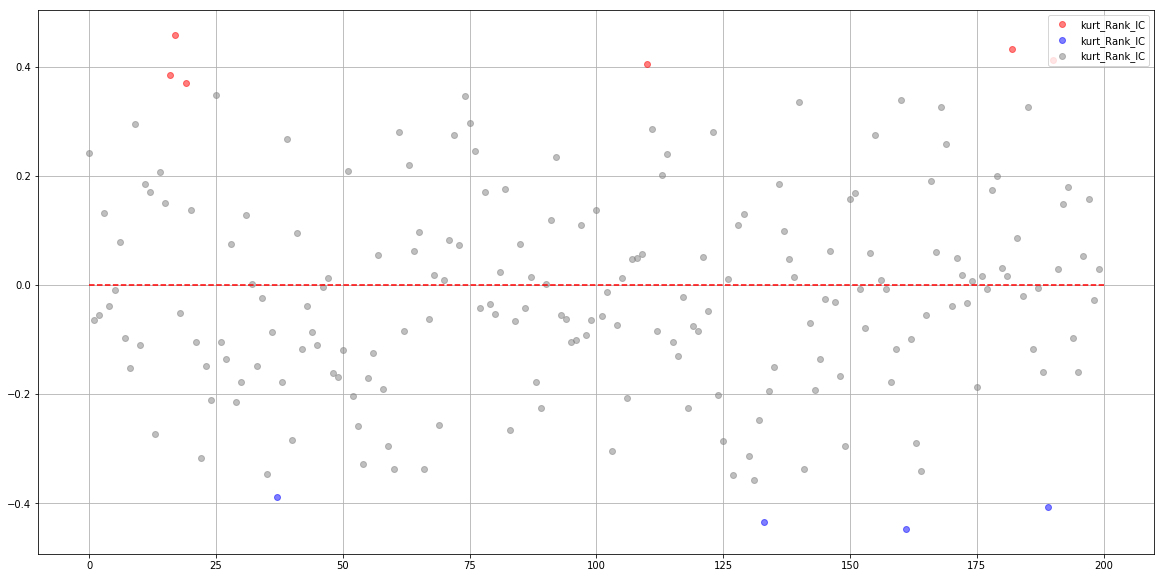

In [97]:
plt.figure(figsize=(20,10))
x11 = weekly_IC.kurt_pvalue[(weekly_IC.kurt_pvalue < 0.05) & (weekly_IC.kurt_Rank_IC >= 0)].index
y11 = weekly_IC.kurt_Rank_IC[x11]
x12 = weekly_IC.kurt_pvalue[(weekly_IC.kurt_pvalue < 0.05) & (weekly_IC.kurt_Rank_IC < 0)].index
y12 = weekly_IC.kurt_Rank_IC[x12]
x2 = weekly_IC.kurt_pvalue[weekly_IC.kurt_pvalue >= 0.05].index
y2 = weekly_IC.kurt_Rank_IC[x2]
print('Positive significant rate: ', len(x11)/weekly_IC.shape[0], 'Negative significant rate: ', len(x12)/weekly_IC.shape[0])
plt.plot(x11, y11, 'o', alpha=0.5, color='red')
plt.plot(x12, y12, 'o', alpha=0.5, color='blue')
plt.plot(x2, y2, 'o', alpha=0.5, label='kurt_Rank_IC', color='grey')
plt.plot(range(201), [0 for i in range(201)], 'r--')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [28]:
# stocks having significant beta1_vol
company_beta_pval[['vol_intercept','b_vol','vol_p_val']][company_beta_pval.vol_p_val <0.05]

,vol_intercept,b_vol,vol_p_val
2,0.072374,-0.438135,0.017269
4,0.056769,-0.352214,0.038677
6,-0.072305,0.414432,0.009109
10,-0.032592,0.168976,0.043937
14,0.043963,-0.373485,0.011842
35,0.045409,-0.331473,0.029954
50,0.038540,-0.427098,0.000424
60,-0.015673,0.274747,0.002999
68,-0.031716,0.314888,0.020459
70,0.020245,-0.231931,0.047019


In [29]:
# stocks having significant beta1_skew
company_beta_pval[['skew_intercept','b_skew','skew_p_val']][company_beta_pval.skew_p_val <0.05]

,skew_intercept,b_skew,skew_p_val
0,-0.000567,0.026495,0.004677
19,0.005617,-0.018127,0.006440
26,0.002490,-0.023121,0.003313
41,-0.006311,-0.023289,0.034013
46,0.023665,-0.014744,0.032396
49,0.015640,-0.021157,0.016374
67,0.009207,-0.030727,0.013108
72,0.012165,0.025246,0.016493
88,-0.035954,-0.031019,0.011795
90,0.006389,-0.012848,0.045278


In [30]:
# Stocks having significant beta1_kurt
company_beta_pval[['kurt_intercept','b_kurt','kurt_p_val']][company_beta_pval.kurt_p_val <0.05]

,kurt_intercept,b_kurt,kurt_p_val
0,-0.023303,0.004333,0.013428
17,-0.054064,0.010981,0.008531
19,-0.021648,0.005712,0.022963
25,-0.056770,0.014807,0.010296
39,0.009758,0.003803,0.048024
51,-0.024527,0.006089,0.045271
60,0.038345,-0.004068,0.038016
103,0.032779,-0.004054,0.017046
118,0.025181,-0.007191,0.005596
127,0.013429,-0.008146,0.017746


In [31]:
company_beta_pval.shape

(200, 9)

In [32]:
company_beta_pval.mean()

vol_intercept     0.000612
b_vol             0.012371
vol_p_val         0.375180
skew_intercept    0.002309
b_skew           -0.001700
skew_p_val        0.439169
kurt_intercept    0.003642
b_kurt           -0.000267
kurt_p_val        0.459431
dtype: float64

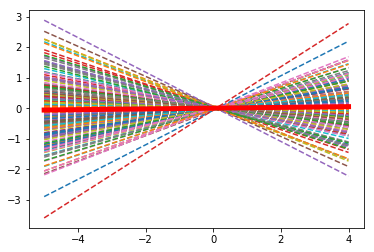

In [111]:
# Linear regression of return on vol
x = np.arange(-5,5)
for row in range(1, company_beta_pval.shape[0]):
    plt.plot(x, company_beta_pval.vol_intercept[row] + x*company_beta_pval.b_vol[row], '--')
plt.plot(x, company_beta_pval.vol_intercept.mean() + x*company_beta_pval.b_vol.mean(), color = 'red', lw = 5)
plt.show()

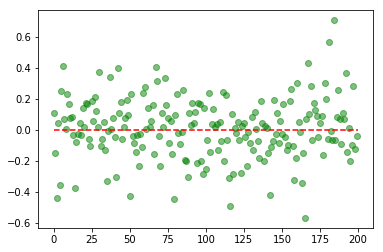

In [34]:
plt.plot(company_beta_pval.b_vol, 'o', alpha = 0.5, color = 'green')
plt.plot(range(201), [0 for i in range(201)], 'r--')

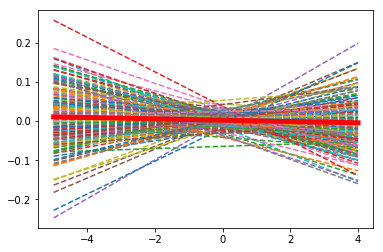

In [35]:
# Linear regression of return on skew
x = np.arange(-5,5)
for row in range(1, company_beta_pval.shape[0]):
    plt.plot(x, company_beta_pval.skew_intercept[row] + x*company_beta_pval.b_skew[row], '--')
plt.plot(x, company_beta_pval.skew_intercept.mean() + x*company_beta_pval.b_skew.mean(), color = 'red', lw = 5)
plt.show()

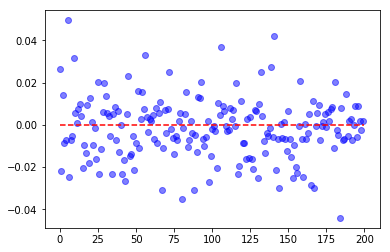

In [36]:
plt.plot(company_beta_pval.b_skew, 'o', alpha = 0.5, color = 'blue')
plt.plot(range(201), [0 for i in range(201)], 'r--')

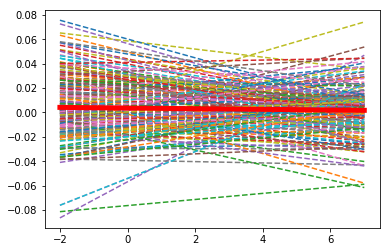

In [37]:
# Linear regression of return on kurt
x = np.arange(-2, 8)
for row in range(1, company_beta_pval.shape[0]):
    plt.plot(x, company_beta_pval.kurt_intercept[row] + x*company_beta_pval.b_kurt[row], '--')
plt.plot(x, company_beta_pval.kurt_intercept.mean() + x*company_beta_pval.b_kurt.mean(), color = 'red', lw = 5)
plt.show()

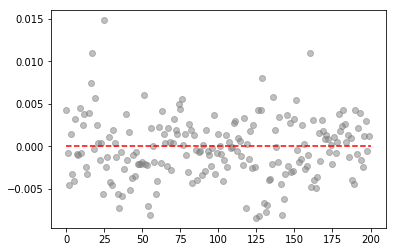

In [38]:
plt.plot(company_beta_pval.b_kurt, 'o', alpha = 0.5, color = 'grey')
plt.plot(range(201), [0 for i in range(201)], 'r--')

In [39]:
group_name = ['group1', 'group2', 'group3']
n_stock_grp = int(30/len(group_name))
return_by_group_vol = pd.DataFrame(columns = group_name)
tmp_list = []
for week in range(total_week-1):
    vol_this_week = sorted([(com, weekly_data[com].RVol[week]) for com in weekly_data.keys()], key = lambda x: x[1])
    #print (vol_this_week)
    group_return_list = []
    for i in range(len(group_name)):
        cur_group, _ = zip(*vol_this_week[n_stock_grp*i : n_stock_grp*i+n_stock_grp])
        sum_r = 0
        for com in cur_group:
            sum_r += weekly_data[com].WR[week+1]
        group_return_list.append(sum_r/n_stock_grp)
    tmp_list.append(dict(zip(group_name, group_return_list)))
return_by_group_vol = return_by_group_vol.append(tmp_list)

In [40]:
return_by_group_vol.sum()

group1    0.258336
group2    0.518434
group3    0.671953
dtype: float64

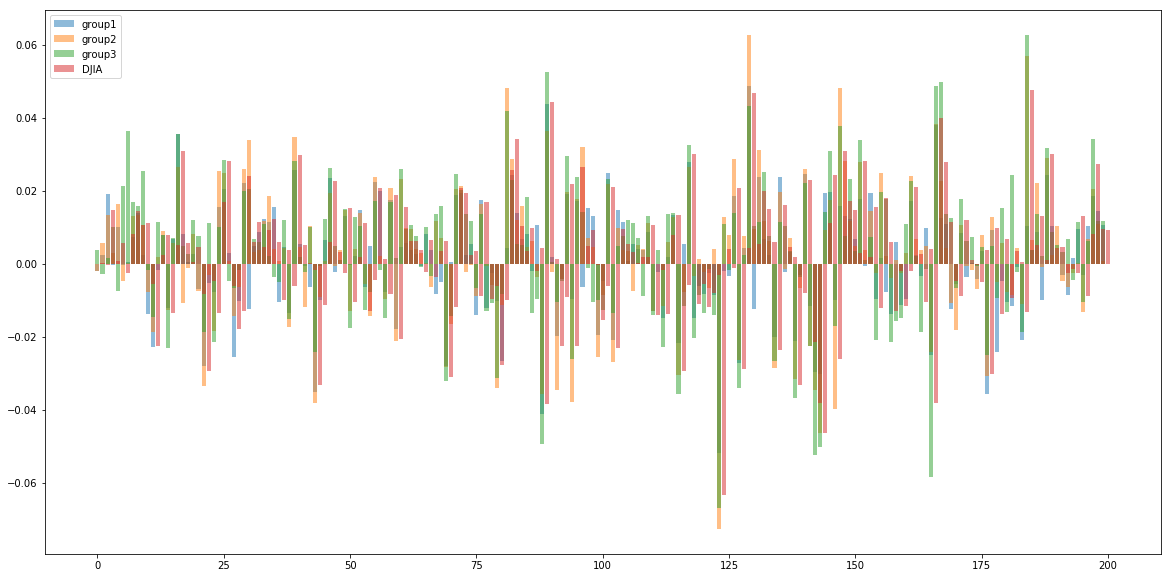

In [104]:
plt.figure(figsize=(20,10))
plt.bar(return_by_group_vol.group1.index, return_by_group_vol.group1, alpha = 0.5, label = 'group1')
plt.bar(return_by_group_vol.group2.index, return_by_group_vol.group2, alpha = 0.5, label = 'group2')
plt.bar(return_by_group_vol.group3.index, return_by_group_vol.group3, alpha = 0.5, label = 'group3')
plt.bar(range(len(DJIA_weekly[:-50])), DJIA_weekly[:-50], alpha = 0.5, label = 'DJIA', lw = 4)
plt.legend(loc = 'upper left')

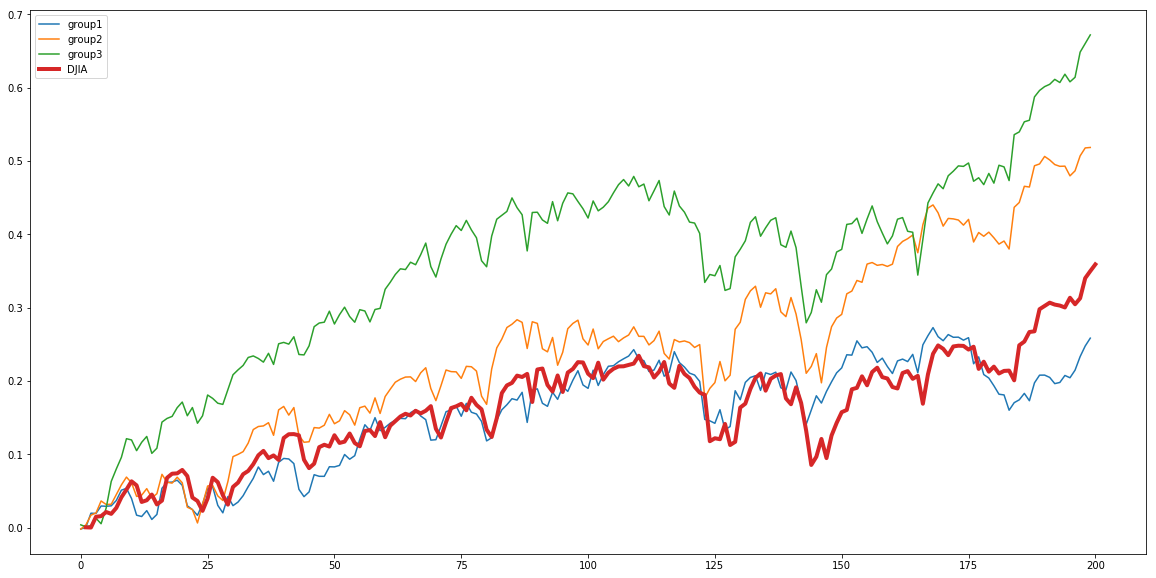

In [100]:
plt.figure(figsize=(20,10))
plt.plot(return_by_group_vol.group1.index, return_by_group_vol.group1.cumsum(), label = 'group1')
plt.plot(return_by_group_vol.group2.index, return_by_group_vol.group2.cumsum(), label = 'group2')
plt.plot(return_by_group_vol.group3.index, return_by_group_vol.group3.cumsum(), label = 'group3')
plt.plot(range(len(DJIA_weekly[:-50])), DJIA_weekly[:-50].cumsum(), label = 'DJIA', lw = 4)
plt.legend(loc = 'upper left')

In [51]:
group_name = ['group1', 'group2', 'group3']
n_stock_grp = int(30/len(group_name))
return_by_group_skew = pd.DataFrame(columns = group_name)
tmp_list = []
for week in range(total_week-1):
    skew_this_week = sorted([(com, weekly_data[com].RSkew[week]) for com in weekly_data.keys()], key = lambda x: x[1])
    group_return_list = []
    for i in range(len(group_name)):
        cur_group = skew_this_week[n_stock_grp*i : n_stock_grp*i+n_stock_grp]
        sum_r = 0
        for com, _ in cur_group:
            sum_r += weekly_data[com].WR[week+1]
        group_return_list.append(sum_r/n_stock_grp)
    tmp_list.append(dict(zip(group_name, group_return_list)))
return_by_group_skew = return_by_group_skew.append(tmp_list)

In [52]:
return_by_group_skew.sum()

group1    0.534724
group2    0.557355
group3    0.356645
dtype: float64

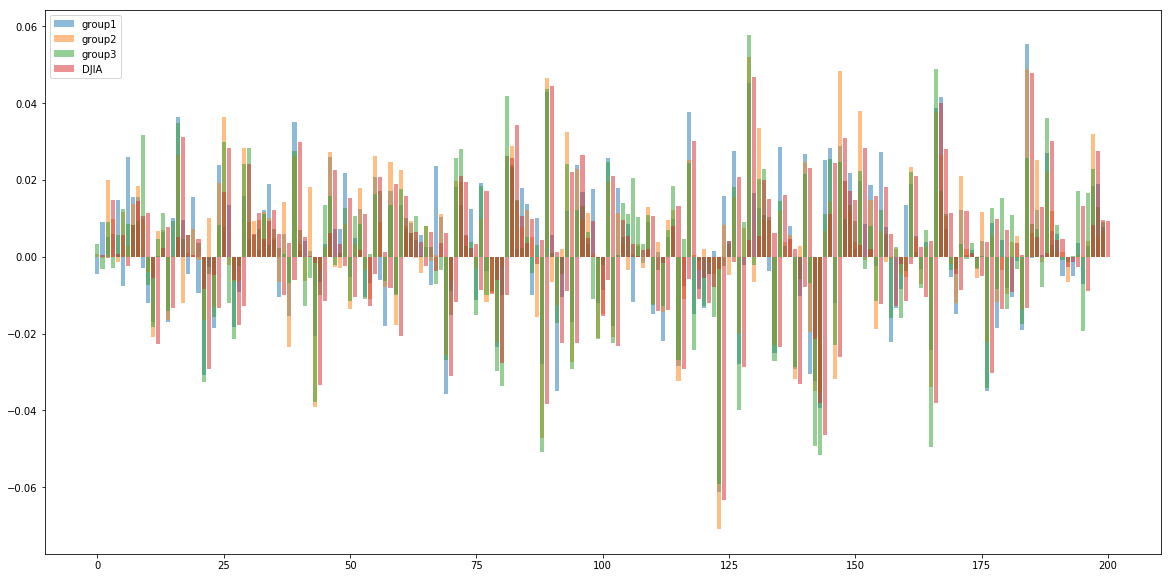

In [105]:
plt.figure(figsize=(20,10))
plt.bar(return_by_group_skew.group1.index, return_by_group_skew.group1, alpha = 0.5, label = 'group1')
plt.bar(return_by_group_skew.group2.index, return_by_group_skew.group2, alpha = 0.5, label = 'group2')
plt.bar(return_by_group_skew.group3.index, return_by_group_skew.group3, alpha = 0.5, label = 'group3')
plt.bar(range(len(DJIA_weekly[:-50])), DJIA_weekly[:-50], alpha = 0.5, label = 'DJIA', lw = 4)
plt.legend(loc = 'upper left')

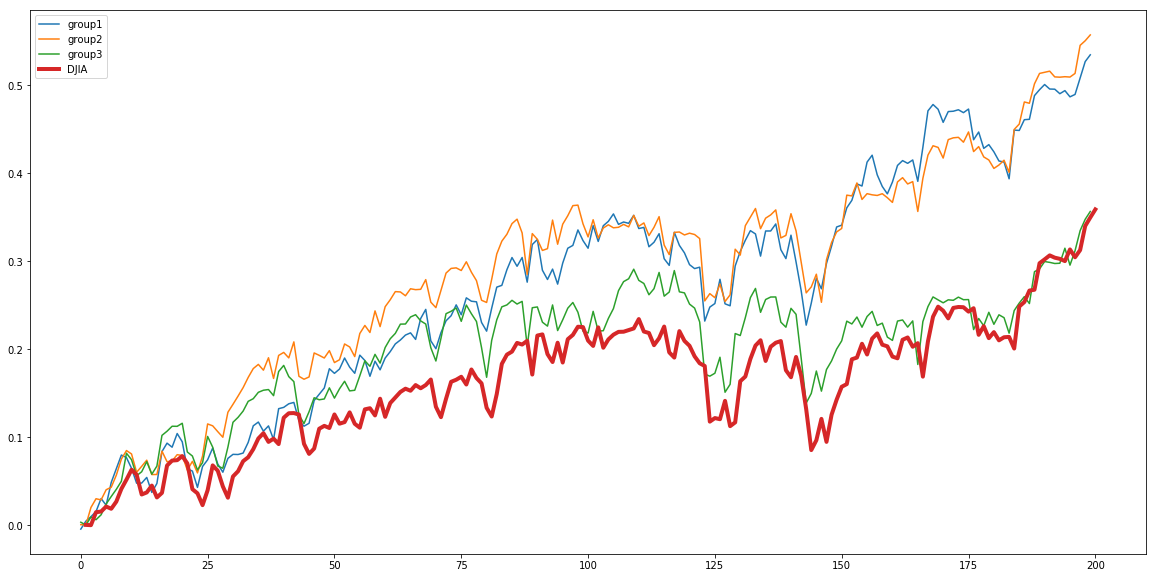

In [107]:
plt.figure(figsize = (20,10))
plt.plot(return_by_group_skew.group1.index, return_by_group_skew.group1.cumsum(), label = 'group1')
plt.plot(return_by_group_skew.group2.index, return_by_group_skew.group2.cumsum(), label = 'group2')
plt.plot(return_by_group_skew.group3.index, return_by_group_skew.group3.cumsum(), label = 'group3')
plt.plot(range(len(DJIA_weekly[:-50])), DJIA_weekly[:-50].cumsum(), label = 'DJIA', lw = 4)
plt.legend(loc = 'upper left')

In [54]:
group_name = ['group1', 'group2', 'group3']
n_stock_grp = int(30/len(group_name))
return_by_group_kurt = pd.DataFrame(columns = group_name)
tmp_list = []
for week in range(total_week-1):
    kurt_this_week = sorted([(com, weekly_data[com].RKurt[week]) for com in weekly_data.keys()], key = lambda x: x[1])
    #print (vol_this_week)
    group_return_list = []
    for i in range(len(group_name)):
        cur_group, _ = zip(*kurt_this_week[n_stock_grp*i : n_stock_grp*i+n_stock_grp])
        sum_r = 0
        for com in cur_group:
            sum_r += weekly_data[com].WR[week+1]
        group_return_list.append(sum_r/n_stock_grp)
    tmp_list.append(dict(zip(group_name, group_return_list)))
return_by_group_kurt = return_by_group_kurt.append(tmp_list)

In [55]:
return_by_group_kurt.sum()

group1    0.465396
group2    0.522745
group3    0.460582
dtype: float64

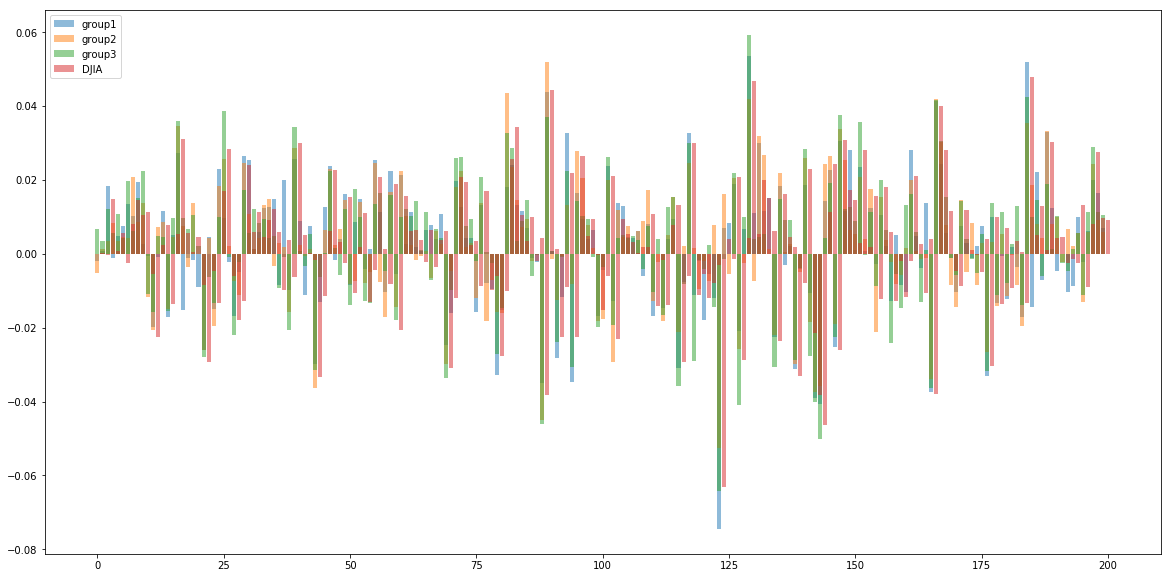

In [108]:
plt.figure(figsize=(20,10))
plt.bar(return_by_group_kurt.group1.index, return_by_group_kurt.group1, alpha = 0.5, label = 'group1')
plt.bar(return_by_group_kurt.group2.index, return_by_group_kurt.group2, alpha = 0.5, label = 'group2')
plt.bar(return_by_group_kurt.group3.index, return_by_group_kurt.group3, alpha = 0.5, label = 'group3')
plt.bar(range(len(DJIA_weekly[:-50])), DJIA_weekly[:-50], alpha = 0.5, label = 'DJIA', lw = 4)
plt.legend(loc = 'upper left')

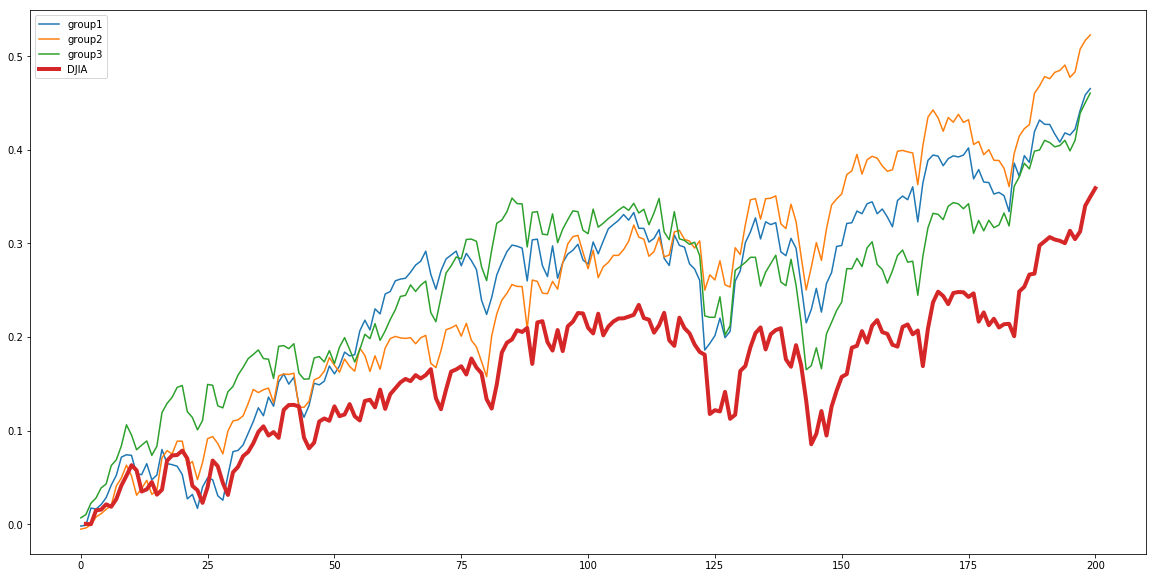

In [109]:
plt.figure(figsize=(20,10))
plt.plot(return_by_group_kurt.group1.index, return_by_group_kurt.group1.cumsum(), label = 'group1')
plt.plot(return_by_group_kurt.group2.index, return_by_group_kurt.group2.cumsum(), label = 'group2')
plt.plot(return_by_group_kurt.group3.index, return_by_group_kurt.group3.cumsum(), label = 'group3')
plt.plot(range(len(DJIA_weekly[:-50])), DJIA_weekly[:-50].cumsum(), label = 'DJIA', lw = 4)
plt.legend(loc = 'upper left')